In [1]:
!pip install fedartml
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

import time
import pickle

import pandas as pd

import matplotlib.pyplot as plt

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
from scipy.stats import cramervonmises

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [59]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=8, verbose=2, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(184, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')

        ]
    )
    return model

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.CvM = self.calculate_CvM(y_train)
        self.epochs_client = epochs_client
        self.round = 0
        self.learning_rate = 0.001

    def calculate_CvM(self,y_train):
        y_train = np.array(y_train,dtype=int)
        cvm = cramervonmises(y_train, 'uniform')
        return math.exp((1/cvm.statistic) * len(y_train))

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.learning_rate = self.learning_rate * 0.995**self.round
        optimizer = SGD(learning_rate=self.learning_rate, momentum=0.9)
        self.round += 1
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2, batch_size = 16, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), len(self.x_train), {'CvM': self.CvM}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

In [4]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union
from functools import reduce

from flwr.common import (
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.fedavg import FedAvg
import numpy as np

class FedCvM(FedAvg):

    def aggregate_impurity(self, results: List[Tuple[NDArrays, int, float]]) -> NDArrays:
      sum_CvM = np.sum([CvM for _, _, CvM in results])
      weighted_weights = [
          [layer * CvM for layer in weights] for weights, _, CvM in results
      ]

      weights_prime: NDArrays = [
          reduce(np.add, layer_updates) / sum_CvM
          for layer_updates in zip(*weighted_weights)
      ]
      return weights_prime

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}
        if not self.accept_failures and failures:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples, fit_res.metrics['CvM'])
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            self.aggregate_impurity(weights_results)
        )

        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [5]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 20

# Define percentage of noniid to be used
Percent_noniid = 1000

Alpha = 0.1

In [6]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "dirichlet", alpha = Alpha)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


11490434/11490434 [==============================] - 0s 0us/step


In [66]:
def calculate_CvM(y_train):
        y_train = np.array(y_train,dtype=int)
        cvm = cramervonmises(y_train, 'uniform')
        return cvm.statistic , cvm

for i, x in enumerate(list_y_train):
  print("Client",i+1,":",calculate_CvM(np.array(x,dtype=float)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Client 1 : (793.9847194050033, CramerVonMisesResult(statistic=793.9847194050033, pvalue=1.6816101167105302e-07))
Client 2 : (555.0187436676798, CramerVonMisesResult(statistic=555.0187436676798, pvalue=1.6010170533764523e-07))
Client 3 : (458.70237358101133, CramerVonMisesResult(statistic=458.70237358101133, pvalue=1.4798580683095253e-07))
Client 4 : (1249.333599928908, CramerVonMisesResult(statistic=1249.333599928908, pvalue=2.4165932921427213e-07))
Client 5 : (1537.3335500180572, CramerVonMisesResult(statistic=1537.3335500180572, pvalue=3.2640614222589903e-07))
Client 6 : (924.0003603603604, CramerVonMisesResult(statistic=924.0003603603604, pvalue=1.887597081973169e-07))
Client 7 : (1174.7876106194692, CramerVonMisesResult(statistic=1174.7876106194692, pvalue=2.774311929076845e-07))
Client 8 : (1142.4369498660544, CramerVonMisesResult(statistic=1142.4369498660544, pvalue=2.67540051557269e-07))
Client 9 : (192.33505747126435, CramerVonMisesResult(statistic=192.33505747126435, pvalue=5.

In [7]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 100
gc.collect()

# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy= FedCvM(
        fraction_fit=0.3,  # Sample 100% of available clients for training
        fraction_evaluate=0.05,  # Sample 50% of available clients for evaluation
        min_fit_clients=6,
        min_evaluate_clients = 1,
        min_available_clients = 20,
        evaluate_fn=evaluate_DNN_CL,
)

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,

)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-02-15 14:19:11,895 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-02-15 14:19:16,811	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-15 14:19:19,759 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3916940083.0, 'memory': 7833880167.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3916940083.0, 'memory': 7833880167.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO flwr 2024-02-15 14:19:19,763 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-15

1250/1250 - 3s - 3s/epoch - 2ms/step


INFO flwr 2024-02-15 14:19:35,675 | server.py:94 | initial parameters (loss, other metrics): 2.3286886, {'accuracy': 0.0701, 'precision': 0.2234183404997465, 'recall': 0.0701, 'f1score': 0.10109721177361207}
INFO:flwr:initial parameters (loss, other metrics): 2.3286886, {'accuracy': 0.0701, 'precision': 0.2234183404997465, 'recall': 0.0701, 'f1score': 0.10109721177361207}
INFO flwr 2024-02-15 14:19:35,680 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-02-15 14:19:35,683 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.328688621520996 / accuracy 0.0701 / f1score 0.10109721177361207 @@@@@@


(DefaultActor pid=159011) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=159011)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=159012) 77/77 - 3s - loss: 1.1729 - accuracy: 0.7015 - val_loss: 0.4159 - val_accuracy: 0.8613 - 3s/epoch - 33ms/step
(DefaultActor pid=159012) 269/269 - 6s - loss: 0.4587 - accuracy: 0.8453 - val_loss: 0.3199 - val_accuracy: 0.9455 - 6s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=159012) 337/337 - 6s - loss: 0.4546 - accuracy: 0.9003 - val_loss: 0.3567 - val_accuracy: 0.9149 - 6s/epoch - 17ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 14:19:53,453 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-02-15 14:19:53,474 | <ipython-input-4-255c7655c4dd>:58 | No fit_metrics_aggregation_fn provided


1250/1250 - 4s - 4s/epoch - 3ms/step


INFO flwr 2024-02-15 14:19:57,837 | server.py:125 | fit progress: (1, 3.65646, {'accuracy': 0.2097, 'precision': 0.992109416973838, 'recall': 0.2097, 'f1score': 0.3459324683011584}, 22.153684500000054)
INFO:flwr:fit progress: (1, 3.65646, {'accuracy': 0.2097, 'precision': 0.992109416973838, 'recall': 0.2097, 'f1score': 0.3459324683011584}, 22.153684500000054)
DEBUG flwr 2024-02-15 14:19:57,842 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.6564600467681885 / accuracy 0.2097 / f1score 0.3459324683011584 @@@@@@


DEBUG flwr 2024-02-15 14:19:59,835 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-02-15 14:19:59,842 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-15 14:19:59,849 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 20)


(DefaultActor pid=159011) 313/313 - 2s - loss: 3.6565 - accuracy: 0.2097 - 2s/epoch - 5ms/step
(DefaultActor pid=159011) 351/351 - 5s - loss: 0.4713 - accuracy: 0.8704 - val_loss: 0.2382 - val_accuracy: 0.9424 - 5s/epoch - 15ms/step
(DefaultActor pid=159012) 77/77 - 2s - loss: 0.7144 - accuracy: 0.7814 - val_loss: 0.3049 - val_accuracy: 0.9270 - 2s/epoch - 32ms/step
(DefaultActor pid=159012) 139/139 - 5s - loss: 0.6586 - accuracy: 0.8066 - val_loss: 0.3899 - val_accuracy: 0.9352 - 5s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=159012) 157/157 - 6s - loss: 0.9002 - accuracy: 0.7361 - val_loss: 0.4312 - val_accuracy: 0.9137 - 6s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 14:20:16,023 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


1250/1250 - 3s - 3s/epoch - 2ms/step


INFO flwr 2024-02-15 14:20:19,348 | server.py:125 | fit progress: (2, 2.4940388, {'accuracy': 0.1046, 'precision': 0.9891311378090458, 'recall': 0.1046, 'f1score': 0.1871362121520963}, 43.66498932800005)
INFO:flwr:fit progress: (2, 2.4940388, {'accuracy': 0.1046, 'precision': 0.9891311378090458, 'recall': 0.1046, 'f1score': 0.1871362121520963}, 43.66498932800005)
DEBUG flwr 2024-02-15 14:20:19,355 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.4940388202667236 / accuracy 0.1046 / f1score 0.1871362121520963 @@@@@@


DEBUG flwr 2024-02-15 14:20:21,962 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-02-15 14:20:21,966 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 20)


(DefaultActor pid=159011) 313/313 - 2s - loss: 2.4940 - accuracy: 0.1046 - 2s/epoch - 7ms/step
(DefaultActor pid=159011) 211/211 - 5s - loss: 0.2122 - accuracy: 0.9612 - val_loss: 0.1022 - val_accuracy: 0.9867 - 5s/epoch - 23ms/step
(DefaultActor pid=159012) 174/174 - 4s - loss: 0.0683 - accuracy: 0.9816 - val_loss: 0.2548 - val_accuracy: 0.9741 - 4s/epoch - 24ms/step
(DefaultActor pid=159012) 266/266 - 5s - loss: 0.0302 - accuracy: 0.9885 - val_loss: 0.2192 - val_accuracy: 0.9810 - 5s/epoch - 18ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 14:20:35,775 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


1250/1250 - 3s - 3s/epoch - 3ms/step


INFO flwr 2024-02-15 14:20:41,275 | server.py:125 | fit progress: (3, 2.2190692, {'accuracy': 0.2949, 'precision': 0.7171415992388286, 'recall': 0.2949, 'f1score': 0.3595115410658429}, 65.59199674799947)
INFO:flwr:fit progress: (3, 2.2190692, {'accuracy': 0.2949, 'precision': 0.7171415992388286, 'recall': 0.2949, 'f1score': 0.3595115410658429}, 65.59199674799947)
DEBUG flwr 2024-02-15 14:20:41,283 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.219069242477417 / accuracy 0.2949 / f1score 0.3595115410658429 @@@@@@


DEBUG flwr 2024-02-15 14:20:43,311 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-02-15 14:20:43,316 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 20)


(DefaultActor pid=159012) 313/313 - 2s - loss: 2.2191 - accuracy: 0.2949 - 2s/epoch - 6ms/step
(DefaultActor pid=159012) 111/111 - 3s - loss: 0.7080 - accuracy: 0.7714 - val_loss: 0.6141 - val_accuracy: 0.8384 - 3s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=159011) 33/33 - 4s - loss: 0.8705 - accuracy: 0.7356 - val_loss: 0.9644 - val_accuracy: 0.6897 - 4s/epoch - 122ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 14:20:55,387 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


1250/1250 - 3s - 3s/epoch - 2ms/step


INFO flwr 2024-02-15 14:21:00,748 | server.py:125 | fit progress: (4, 2.0088007, {'accuracy': 0.3381, 'precision': 0.8234570570788515, 'recall': 0.3381, 'f1score': 0.40912375578427174}, 85.06466308899962)
INFO:flwr:fit progress: (4, 2.0088007, {'accuracy': 0.3381, 'precision': 0.8234570570788515, 'recall': 0.3381, 'f1score': 0.40912375578427174}, 85.06466308899962)
DEBUG flwr 2024-02-15 14:21:00,755 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.008800745010376 / accuracy 0.3381 / f1score 0.40912375578427174 @@@@@@


DEBUG flwr 2024-02-15 14:21:03,559 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-02-15 14:21:03,563 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 20)


(DefaultActor pid=159011) 313/313 - 2s - loss: 2.0088 - accuracy: 0.3381 - 2s/epoch - 8ms/step
(DefaultActor pid=159011) 211/211 - 3s - loss: 0.1077 - accuracy: 0.9807 - val_loss: 0.1090 - val_accuracy: 0.9867 - 3s/epoch - 16ms/step [repeated 3x across cluster]
(DefaultActor pid=159012) 269/269 - 5s - loss: 0.1312 - accuracy: 0.9550 - val_loss: 0.2059 - val_accuracy: 0.9455 - 5s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=159011) 83/83 - 4s - loss: 0.6717 - accuracy: 0.8083 - val_loss: 0.4033 - val_accuracy: 0.9257 - 4s/epoch - 52ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 14:21:25,379 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


(DefaultActor pid=159012) 337/337 - 11s - loss: 0.2995 - accuracy: 0.9139 - val_loss: 0.2155 - val_accuracy: 0.9399 - 11s/epoch - 33ms/step
1250/1250 - 3s - 3s/epoch - 2ms/step


INFO flwr 2024-02-15 14:21:28,730 | server.py:125 | fit progress: (5, 1.3888627, {'accuracy': 0.4766, 'precision': 0.8175137693971002, 'recall': 0.4766, 'f1score': 0.5235239142940386}, 113.04686111199953)
INFO:flwr:fit progress: (5, 1.3888627, {'accuracy': 0.4766, 'precision': 0.8175137693971002, 'recall': 0.4766, 'f1score': 0.5235239142940386}, 113.04686111199953)
DEBUG flwr 2024-02-15 14:21:28,740 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.3888627290725708 / accuracy 0.4766 / f1score 0.5235239142940386 @@@@@@


DEBUG flwr 2024-02-15 14:21:31,465 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2024-02-15 14:21:31,468 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 20)


(DefaultActor pid=159012) 313/313 - 2s - loss: 1.3889 - accuracy: 0.4766 - 2s/epoch - 8ms/step
(DefaultActor pid=159012) 83/83 - 3s - loss: 0.5182 - accuracy: 0.8528 - val_loss: 0.3732 - val_accuracy: 0.9122 - 3s/epoch - 37ms/step
(DefaultActor pid=159012) 306/306 - 5s - loss: 0.0177 - accuracy: 0.9955 - val_loss: 0.1107 - val_accuracy: 0.9816 - 5s/epoch - 18ms/step [repeated 3x across cluster]


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


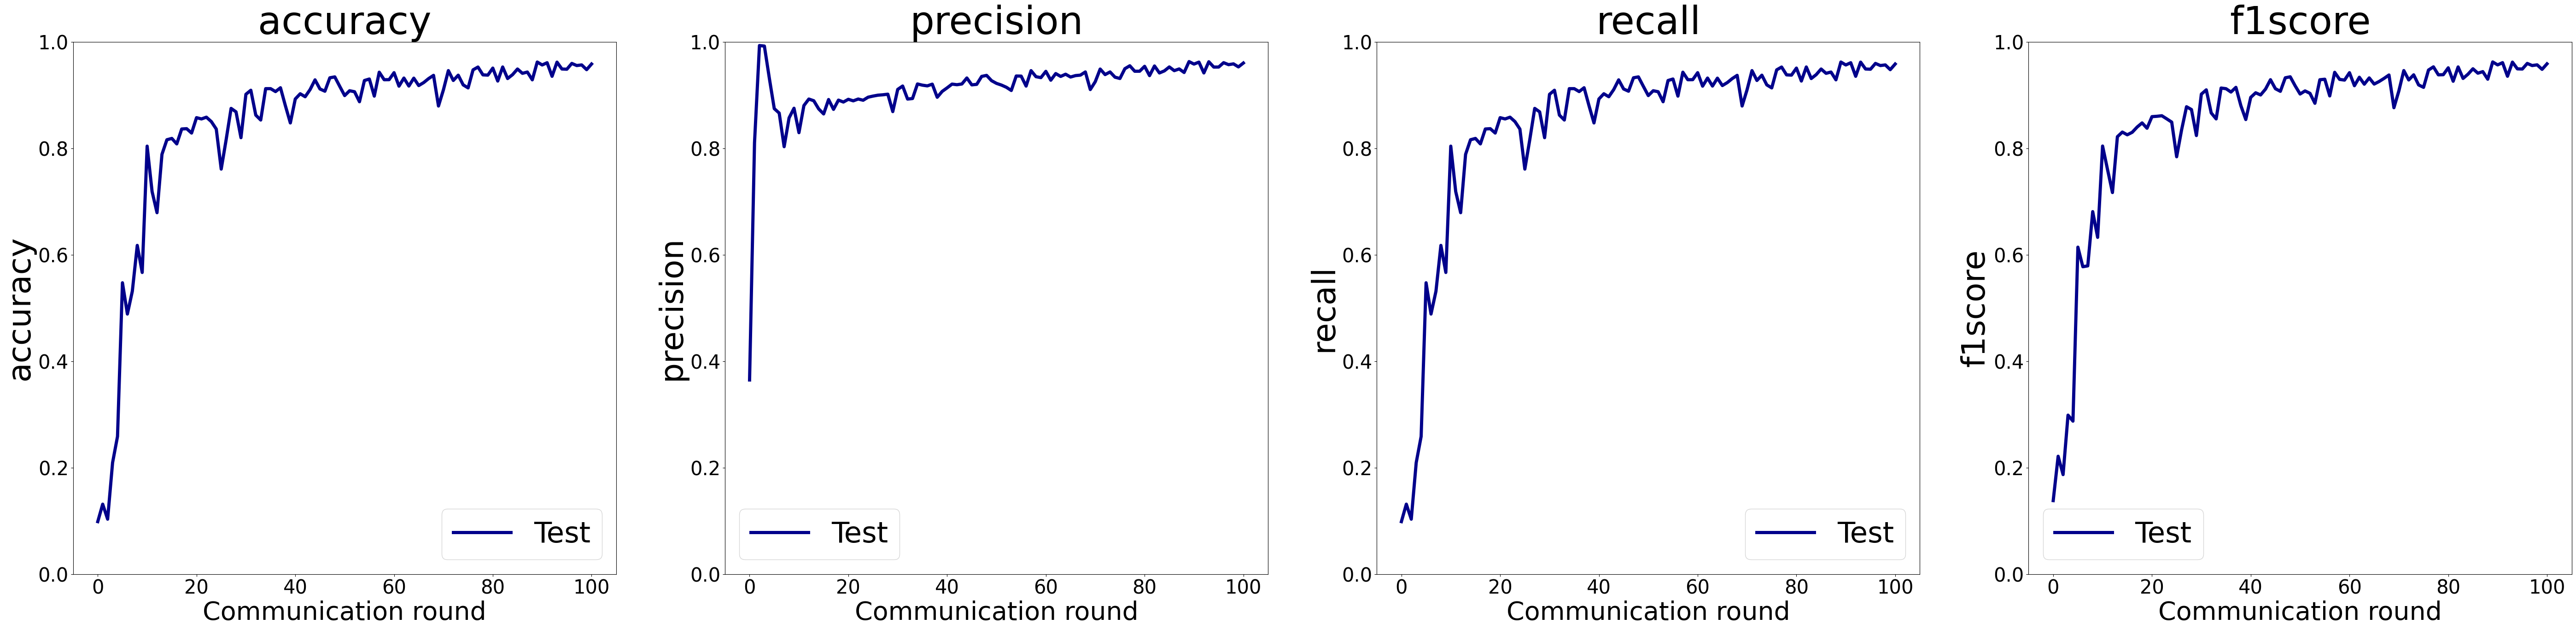

In [9]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])